# Regression tests

## What are we using Regression for?
We'll be using regression in order to find the yeild of a farm.  
(TODO)

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# supporess the annoying sns future deprecation warnings
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
### IGNORE BUT KEEP: this code cleans and converts "./temp/apy.csv" to the needed state-specific dataset ###

# initial_df = pd.read_csv("./temp/apy.csv")

# # getting rid of the null values
# initial_df = initial_df.dropna()
# initial_df = initial_df.drop(
#     initial_df[initial_df["State_Name"] != "Maharashtra"].index
# ).drop(columns=["State_Name"])

# # export to new CSV
# initial_df.to_csv("./data/crop.yield.prediction.csv", index=False)

In [3]:
df = pd.read_csv("./data/crop.yield.prediction.csv")
df

,District_Name,Crop_Year,Season,Crop,Area,Production
0,AHMEDNAGAR,1997,Autumn,Maize,1.0,1113.0
1,AHMEDNAGAR,1997,Kharif,Arhar/Tur,17600.0,6300.0
2,AHMEDNAGAR,1997,Kharif,Bajra,274100.0,152800.0
3,AHMEDNAGAR,1997,Kharif,Gram,40800.0,18600.0
4,AHMEDNAGAR,1997,Kharif,Jowar,900.0,1100.0
...,...,...,...,...,...,...
12491,YAVATMAL,2014,Rabi,Jowar,4000.0,3300.0
12492,YAVATMAL,2014,Rabi,Maize,1300.0,200.0
12493,YAVATMAL,2014,Rabi,Wheat,29100.0,26800.0
12494,YAVATMAL,2014,Summer,Groundnut,9400.0,11500.0


## Information about the dataset
The given dataset was developed from another larger but more redundant dataset from data.gov.in:  
<https://data.gov.in/resource/district-wise-season-wise-crop-production-statistics-1997>

Now we'll turn `District_Name`, `Season`, `Crop` to numerical values.

In [4]:
unique_districts = np.unique(df["District_Name"]).tolist()
unique_seasons = np.unique(df["Season"]).tolist()
unique_crops = np.unique(df["Crop"]).tolist()

len(unique_districts), len(unique_seasons), len(unique_crops)

(35, 5, 34)

Now we'll map the data accordingly:  
Update: We'll also drop the year data for now...
Update 2: We'll modify `Season` later.

In [5]:
df["District_Name"] = df["District_Name"].map(lambda x: unique_districts.index(x))
# df["Season"] = df["Season"].map(lambda x: unique_seasons.index(x))
df["Crop"] = df["Crop"].map(lambda x: unique_crops.index(x))

df = df.drop(columns=["Crop_Year"])

In [6]:
df

,District_Name,Season,Crop,Area,Production
0,0,Autumn,10,1.0,1113.0
1,0,Kharif,0,17600.0,6300.0
2,0,Kharif,1,274100.0,152800.0
3,0,Kharif,5,40800.0,18600.0
4,0,Kharif,8,900.0,1100.0
...,...,...,...,...,...
12491,34,Rabi,8,4000.0,3300.0
12492,34,Rabi,10,1300.0,200.0
12493,34,Rabi,32,29100.0,26800.0
12494,34,Summer,7,9400.0,11500.0


## Decision: Produce in tonne or tonne/hectare?

### Comparing original data

/home/smv/Code/fresh-fields/ml-official/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


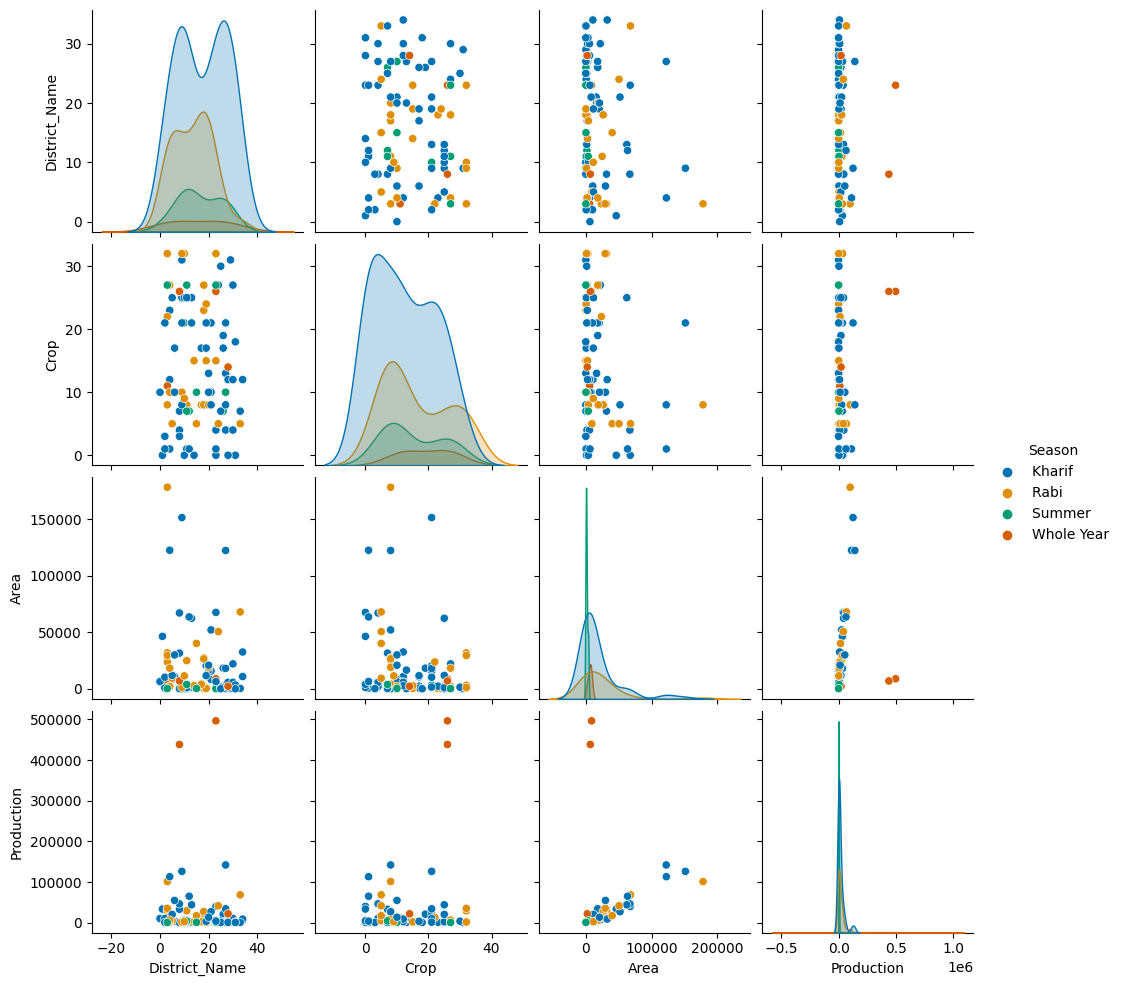

In [7]:
sns.pairplot(df.sample(n=100), hue="Season", palette="colorblind")
# colorblind palette for more vibrant colours

Clearly the area graph here is quite useless. Let's just remove it instead of wasting our time. 

In [8]:
df["Production"] = df["Production"].div(df["Area"])
df = df.drop(columns=["Area"])
df = df.drop(df[df["Production"] > 50].index)
df

,District_Name,Season,Crop,Production
1,0,Kharif,0,0.357955
2,0,Kharif,1,0.557461
3,0,Kharif,5,0.455882
4,0,Kharif,8,1.222222
5,0,Kharif,10,1.068182
...,...,...,...,...
12490,34,Rabi,5,0.846753
12491,34,Rabi,8,0.825000
12492,34,Rabi,10,0.153846
12493,34,Rabi,32,0.920962


In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
District_Name,12051.0,16.442287,10.186276,0.0,7.0,17.000000,25.000,34.0
Crop,12051.0,15.172683,9.621741,0.0,7.0,13.000000,23.000,33.0
Production,12051.0,1.140083,3.211298,0.0,0.4,0.666667,1.125,50.0


/home/smv/Code/fresh-fields/ml-official/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


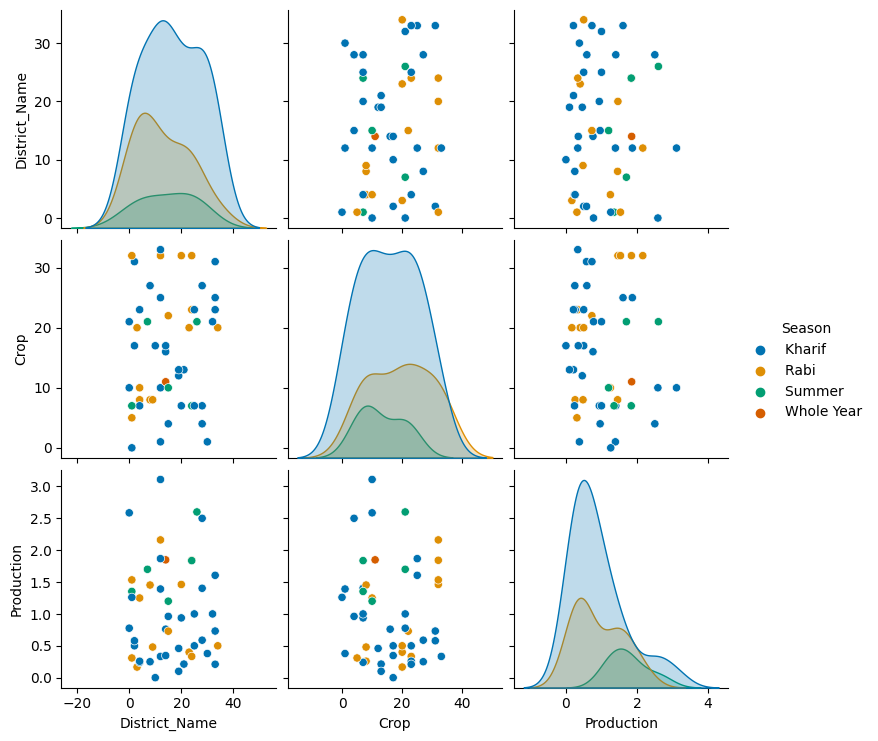

In [10]:
# colorblind palette for more vibrant colours
outplot = sns.pairplot(df.sample(n=50), hue="Season", palette="colorblind")

In [11]:
# NOW modifying season
df["Season"] = df["Season"].map(lambda x: unique_seasons.index(x))

NOTE: the data at index 0 seems a bit off to me but let's see...

## Final decision: Training with data in *tonne/hectare*

In [12]:
from sklearn.model_selection import train_test_split

X = df.loc[:, df.columns[0:-1]].to_numpy()
y = df["Production"].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Comparing 8 different regression models:

Ideally the best one for this dataset is Random Forest Regressor...
<https://www.ijircst.org/DOC/7-crop-yield-prediction-using-random-forest-algorithm-for-major-cities-in-maharashtra-state.pdf>

## List of regression models:
1. Linear regression
2. Polynomial regression
3. Ridge regression
4. Bayesian regression
5. Partial Least Squares Regression
6. Elastic Net Regression
7. SVM Regression
8. Random forest regression

model: RandomForestRegressor
  MAE:      0.40792657846286995
  RMSE:     2.15415551297673
  accuracy: 0.6767974145313229
model: SVR
  MAE:      0.732161624355824
  RMSE:     3.4864354597134657
  accuracy: 0.2245573339505723
model: Ridge
  MAE:      1.0917635832794264
  RMSE:     3.556479547797553
  accuracy: -0.09237500502405993


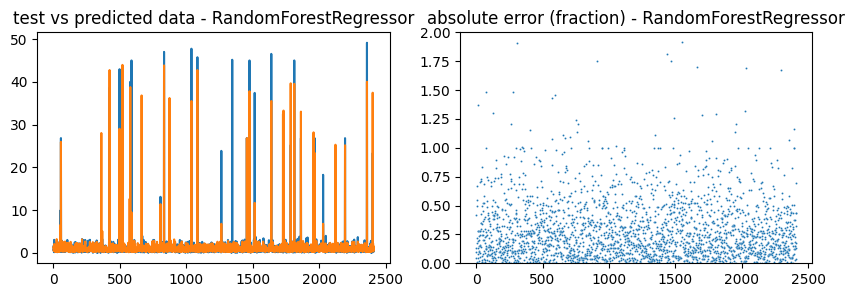

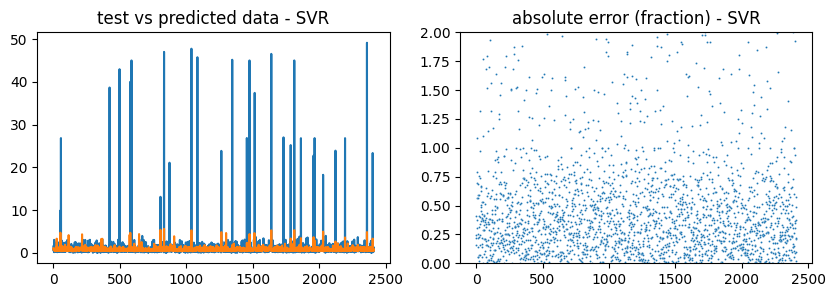

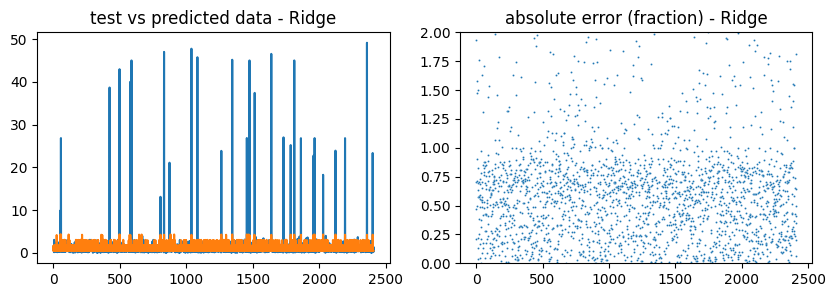

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge


def regression_result(model):
    name = model.__class__.__name__

    pipe = make_pipeline(StandardScaler(), model)

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(f"model: {name}")
    print(f"  MAE:      {mean_absolute_error(y_test, y_pred)}")
    print(f"  RMSE:     {mean_squared_error(y_test, y_pred, squared=False)}")
    print(f"  accuracy: {1 - np.average(abs((y_test - y_pred) / y_pred))}")

    fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
    ax[0].set_title(f"test vs predicted data - {name}")
    sns.lineplot(y_test, ax=ax[0])
    sns.lineplot(y_pred, ax=ax[0])

    ax[1].set_title(f"absolute error (fraction) - {name}")
    sns.scatterplot(abs(y_pred - y_test) / y_pred, ax=ax[1], s=2).set_ylim(0, 2)


### ------ ###

forest = RandomForestRegressor(random_state=42, n_estimators=20)
svm = SVR()
ridge = Ridge(alpha=0.5)

regressors = [forest, svm, ridge]

for model in regressors:
    regression_result(model)

In [25]:
unique_crops, unique_districts, unique_season

NameError: name 'unique_season' is not defined